**Predicting Functional Threshold Power (FTP)**

In [1]:
import os
import pandas as pd
import strava_export as strava
from tabulate import tabulate as tab

athletes = pd.read_csv(os.path.join(strava.pro_dir, 'athletes.csv'))
rides = pd.read_csv(os.path.join(strava.pro_dir, 'rides.csv'))

print(tab(athletes, headers='keys', tablefmt='psql', showindex='false'))

rides_all = rides.merge(athletes[['id', 'sex', 'weight']], how='left', left_on='id', right_on='id')
print('Total rides: {:,}'.format(len(rides_all)))

+-------------+---------+------------+-------+----------+-------------+
| firstname   |      id | lastname   | sex   |   weight |   num_rides |
|-------------+---------+------------+-------+----------+-------------|
| Alun        | 2163639 | Hanford    | M     |       68 |         225 |
| David       | 6377876 | Rich       | M     |       72 |         164 |
| James       | 4917647 | Kinley     | M     |       68 |         239 |
+-------------+---------+------------+-------+----------+-------------+
Total rides: 628


**Data Exploration**
* Discussion of certain features about the dataset (inc. samples)
* Report and discussion of statistics about the dataset
* Discussion of any abnormalities or characteristics that need to be addressed (e.g. categorical variables, missing values, or outliers)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def num_outliers(series):
    '''Number of outliers using Tukey's Method'''
    vals = series.fillna(0).values
    q1 = np.percentile(vals, 25.)
    q3 = np.percentile(vals, 75.)
    tk_step = (q3-q1)*1.5
    return sum(series < q1-tk_step) + sum(series > q3+tk_step)

def explore_report(df, cols):
    print(tab(df[cols].describe(), headers='keys', tablefmt='psql', floatfmt='.2f'))

    stats = defaultdict(list)
    for c in cols:
        series = df[c]
        stats[c].append(sum(series.isna()))
        stats[c].append(100/len(series)*sum(series.isna()))
        stats[c].append(round(series.skew(),2))
        stats[c].append(num_outliers(series))

    stats_pd = pd.DataFrame.from_dict(stats)
    stats_pd.rename(index={0:'nan', 1:'nan_perc', 2:'skew', 3:'outliers'}, inplace=True)
    print(tab(stats_pd, headers='keys', tablefmt='psql', floatfmt='.2f'))

    axes = df[cols].hist(alpha=0.5, bins=50, color='#333e47', figsize=(12, 8), grid=False)
    for ax in axes:    
        for x in ax:
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
    plt.show()

Explore **cadence** & **heart rate**

**Cadence**
* `88%` of rides have cadence data (good coverage)
* IQR is narrow but within expected ranges
* `max_cadence` max of `246` is physically difficult to reach, so possibly a sensor or other data anomoly (fixed by removing the `56` outliers)
* Both cadence features have minimal skew

**Heart Rate**
* Only `54%` of rides have heart rate data. Not all athletes wear a heart rate monitor for every ride, if at all, so this is expected. Heart rate is a key indication of effort, so despite the poor coverage it shouldn't be removed
* Statistics seem sensible and within expected ranges. Max heart rate of `214` is rare, but not physically impossible
* Marginally higher skew than the cadence features, but not enough to be concered about


+-------+---------------+---------------+------------------+------------------+
|       |   avg_cadence |   max_cadence |   avg_heart_rate |   max_heart_rate |
|-------+---------------+---------------+------------------+------------------|
| count |        550.00 |        550.00 |           337.00 |           337.00 |
| mean  |         80.05 |        114.61 |           140.80 |           165.27 |
| std   |         11.54 |         28.17 |            16.92 |            18.80 |
| min   |          5.00 |          9.00 |             0.00 |             0.00 |
| 25%   |         77.00 |        100.00 |           133.00 |           157.00 |
| 50%   |         82.00 |        110.00 |           142.00 |           168.00 |
| 75%   |         86.00 |        121.00 |           149.00 |           177.00 |
| max   |        101.00 |        246.00 |           178.00 |           214.00 |
+-------+---------------+---------------+------------------+------------------+
+----------+---------------+------------

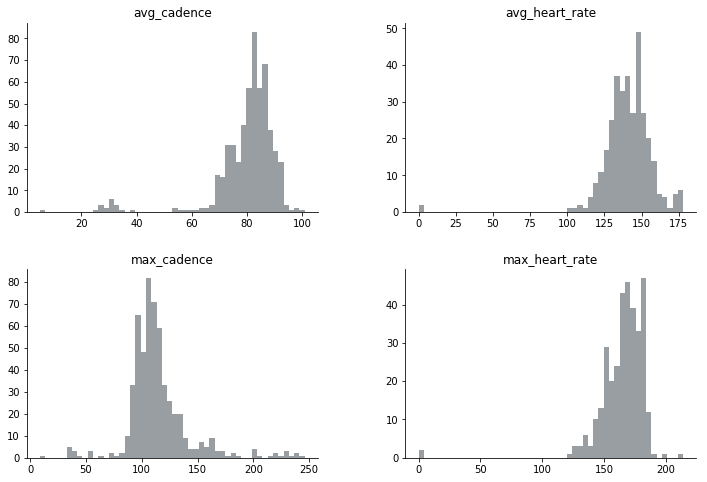

In [10]:
# explore cadence & heart rate
explore_report(
    rides_all,
    ['avg_cadence', 
     'max_cadence',
     'avg_heart_rate',
     'max_heart_rate']
)

Explore **power** & **stress**

**Power**
* Only `47%` of rides have power data. Power data is collected from a power meter (strain gauge) attached to a bike, or an indoor "turbo" trainer. Not all athletes have a power meter so poor coverage is expected when using Strava data. More specific cycling applications, such as TrainerRoad, rely on power numbers and will have better coverage
* `max_power` is highly skewed due to the `9` outlying values (max power of 22,276 watts is physically impossible). Removing these outliers should significantly reduce the skew
* `normalized_power` is an important variable. Also known as _weighted average power_ it takes ride variation into account (e.g. terrain, intervals, rest, etc) to provide a better estimate of average power if you rode with a constant power output for the entire ride. It provides the ability to compare effort between rides
* Considering that the dataset includes accurate `ftp` values (what we're trying to predict), I think Strava's estimated `threshold_power` feature can be omitted

**Stress**
* `training_stress_score` (TSS) is a measure of how hard a ride was. The higher the TSS, the more potential fitness gained from the ride, and the greater need for recovery afterwards [1]. Again, despite the relatively poor coverage, this is an important variable to keep
* `training_stress_score` is highly skewed due to the `27` outlying values, which should be removed

[1] https://science4performance.com/2017/04/20/strava-ride-statistics/

+-------+-------------+-------------+--------------------+-------------------+-------------------------+
|       |   avg_power |   max_power |   normalized_power |   threshold_power |   training_stress_score |
|-------+-------------+-------------+--------------------+-------------------+-------------------------|
| count |      295.00 |      295.00 |             295.00 |            288.00 |                  293.00 |
| mean  |      175.06 |      615.34 |             192.79 |            224.95 |                  111.14 |
| std   |       33.26 |     1781.05 |              36.48 |             48.83 |                  152.81 |
| min   |        1.00 |       64.00 |               6.00 |            200.00 |                    0.00 |
| 25%   |      162.00 |      293.50 |             176.00 |            200.00 |                   52.20 |
| 50%   |      175.00 |      365.00 |             193.00 |            200.00 |                   87.80 |
| 75%   |      189.00 |      584.50 |             208.0

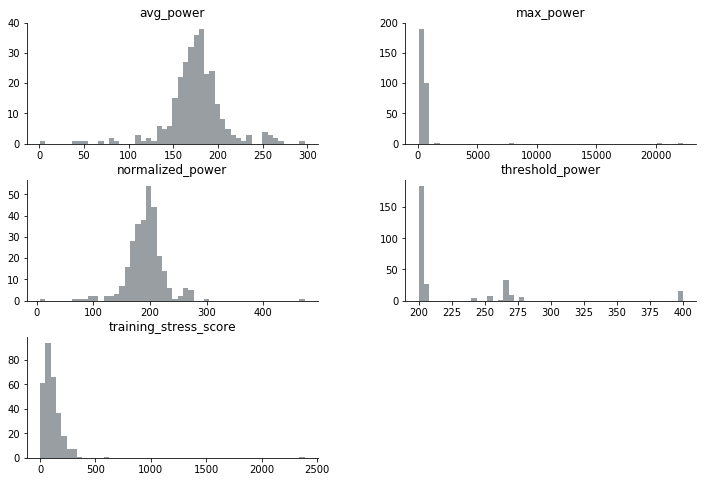

In [12]:
# explore power & stress
explore_report(
    rides_all,
    ['avg_power', 
     'max_power', 
     'normalized_power', 
     'threshold_power',    
     'training_stress_score']
)

Explore **speed**

* Good coverage and within expected ranges
* Minimal skew
* `enhanced` variables appear to be the same and can be removed
* `avg_speed` has `124` outliers that should be removed

+-------+-------------+----------------------+----------------------+-------------+
|       |   avg_speed |   enhanced_avg_speed |   enhanced_max_speed |   max_speed |
|-------+-------------+----------------------+----------------------+-------------|
| count |      628.00 |               628.00 |               529.00 |      529.00 |
| mean  |        6.49 |                 6.49 |                14.06 |       14.06 |
| std   |        3.39 |                 3.39 |                 3.53 |        3.53 |
| min   |        0.00 |                 0.00 |                 0.00 |        0.00 |
| 25%   |        6.11 |                 6.11 |                12.32 |       12.32 |
| 50%   |        7.53 |                 7.53 |                14.63 |       14.63 |
| 75%   |        8.49 |                 8.49 |                16.19 |       16.19 |
| max   |       18.06 |                18.06 |                38.15 |       38.15 |
+-------+-------------+----------------------+----------------------+-------

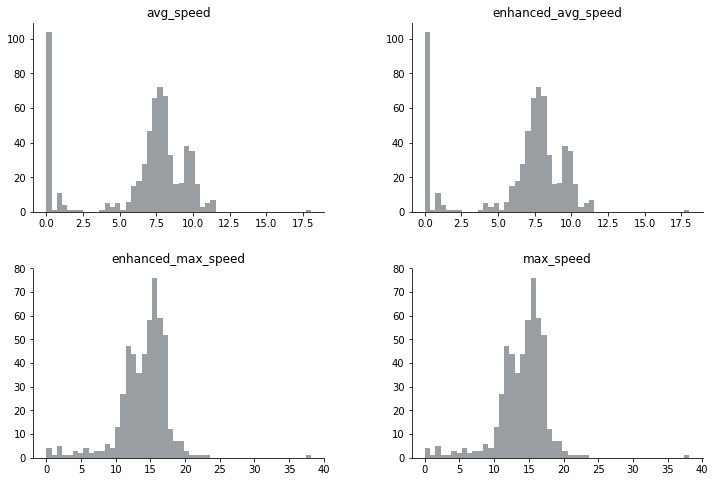

In [13]:
# explore speed
explore_report(
    rides_all,
    ['avg_speed', 
     'enhanced_avg_speed', 
     'enhanced_max_speed', 
     'max_speed']
)

Explore **totals** (pt1)

* Good coverage and within expected ranges
* Minimal skew
* Small number of outliers to be removed
* `ascent` and `decent` variables have many examples with `0` values due to indoor rides
* `total_fat_calories` contains no valuable data and can be removed

+-------+----------------+-----------------+----------------+------------------+----------------------+
|       |   total_ascent |   total_descent |   total_cycles |   total_calories |   total_fat_calories |
|-------+----------------+-----------------+----------------+------------------+----------------------|
| count |         553.00 |          551.00 |         506.00 |           605.00 |               314.00 |
| mean  |         338.47 |          339.25 |        6802.61 |          1162.14 |                 0.00 |
| std   |         376.38 |          377.48 |        4703.19 |           943.41 |                 0.00 |
| min   |           0.00 |            0.00 |           1.00 |             0.00 |                 0.00 |
| 25%   |           2.00 |            2.00 |        3671.25 |           555.00 |                 0.00 |
| 50%   |         213.00 |          208.00 |        5414.50 |           852.00 |                 0.00 |
| 75%   |         590.00 |          596.00 |        8541.25 |   

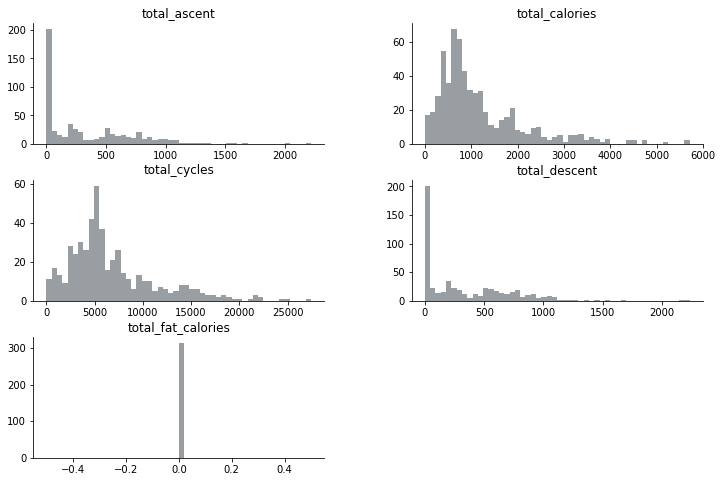

In [15]:
# explore totals pt1
explore_report(
    rides_all,
    ['total_ascent',
     'total_descent',         
     'total_cycles', 
     'total_calories',
     'total_fat_calories']
)

Explore **totals** (pt2)

* Good coverage
* `total_elapsed_time` is highly skewed due to the `27` outlying values, which should be removed
* `total_distance` and `total_timer_time` also have outlying values that should be removed, but these features have minimal skew

+-------+------------------+----------------------+--------------------+
|       |   total_distance |   total_elapsed_time |   total_timer_time |
|-------+------------------+----------------------+--------------------|
| count |           628.00 |               628.00 |             628.00 |
| mean  |         38136.23 |             16923.31 |            5571.79 |
| std   |         33924.77 |             98511.40 |            4080.81 |
| min   |             0.00 |                 0.67 |               0.67 |
| 25%   |          9041.35 |              2987.90 |            2734.45 |
| 50%   |         31701.35 |              4200.18 |            4091.18 |
| 75%   |         53002.00 |              8345.99 |            7190.24 |
| max   |        164129.56 |           1721086.11 |           27256.93 |
+-------+------------------+----------------------+--------------------+
+----------+------------------+----------------------+--------------------+
|          |   total_distance |   total_elapsed_

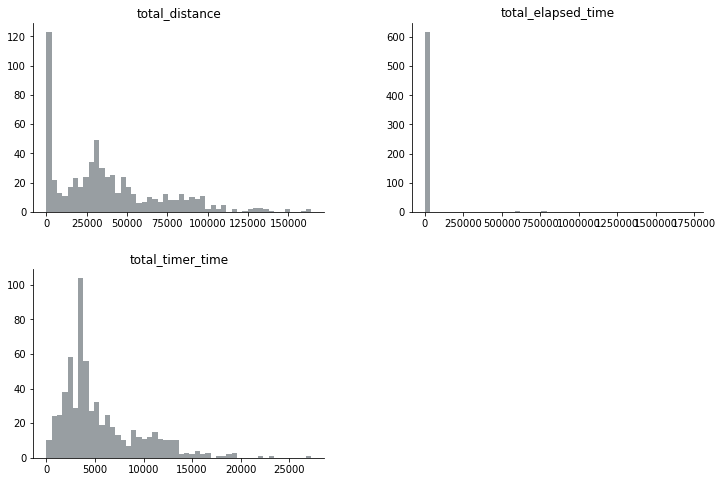

In [17]:
# explore totals pt2
explore_report(
    rides_all,
    ['total_distance', 
     'total_elapsed_time',
     'total_timer_time']
)

**Feature Engineering**

Automate the feature engineering process using _**Deep Feature Synthesis**_:
* https://docs.featuretools.com/automated_feature_engineering/afe.html
* http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf

In [118]:
import featuretools as ft
print('featuretools version: {}'.format(ft.__version__))

es = ft.EntitySet(id='ftp_proba')

es = es.entity_from_dataframe(
    entity_id = 'athletes',
    dataframe = athletes[['id', 'sex', 'weight']],
    index = 'id',
    variable_types = {
        'id': ft.variable_types.Index,
        'sex': ft.variable_types.Categorical,
        'weight': ft.variable_types.Numeric
    }
)

es = es.entity_from_dataframe(
    entity_id = 'rides',
    dataframe = rides,
    index = 'ride_id',
    make_index = True,
    time_index = 'timestamp'
)

rel = ft.Relationship(
    es['athletes']['id'],
    es['rides']['id']
)
es = es.add_relationship(rel)

print(es)

cutoff_dt = es['rides'].df['timestamp']
print(cutoff_dt)
# check index matches!

featuretools version: 0.3.1
Entityset: ftp_proba
  Entities:
    athletes [Rows: 2, Columns: 3]
    rides [Rows: 784, Columns: 25]
  Relationships:
    rides.id -> athletes.id
766   2013-09-27 16:28:50
548   2014-01-17 13:49:29
553   2014-01-18 17:05:48
732   2014-01-27 16:03:02
639   2014-01-29 13:37:32
386   2014-02-01 11:13:32
607   2014-02-03 08:19:34
722   2014-02-07 19:50:38
539   2014-02-09 08:14:33
210   2014-02-09 13:38:34
554   2014-02-14 08:20:05
731   2014-02-22 12:06:28
750   2014-02-22 17:07:16
457   2014-02-23 13:13:21
43    2014-03-06 07:26:01
231   2014-03-08 11:46:51
739   2014-03-09 20:51:46
23    2014-03-10 16:27:35
415   2014-03-10 16:43:06
384   2014-03-11 07:27:27
258   2014-03-11 16:47:31
355   2014-03-13 07:26:47
488   2014-03-15 14:55:39
498   2014-03-17 17:53:06
105   2014-03-17 18:13:30
292   2014-03-19 07:16:09
367   2014-03-20 07:19:01
271   2014-03-20 16:57:07
207   2014-03-24 07:23:52
499   2014-03-27 07:28:11
              ...        
265   2018-05-10 0